### Attempt to improve MSE of DK compared to basic GP

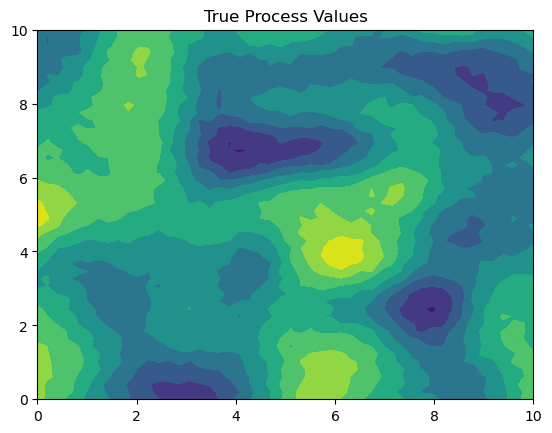

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(23)
torch.manual_seed(23)

# Create synthetic 2D data
N = 50
x = np.linspace(0, 10, N)
y = np.linspace(0, 10, N)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T  # 2D coordinates

# Exponential kernel (covariance function)
def exponential_kernel(s1, s2, length_scale):
    sqdist = np.sum(s1**2, axis=1).reshape(-1, 1) + np.sum(s2**2, axis=1) - 2 * np.dot(s1, s2.T)
    return np.exp(-0.5 * sqdist / length_scale**2)

length_scale = 1.0
cov_matrix = exponential_kernel(grid_points, grid_points, length_scale)
noise_var = 0.01  # Nugget variance
nugget = np.eye(grid_points.shape[0]) * noise_var
cov_matrix += nugget  # Covariance matrix with noise

# Generate process values from multivariate normal
mean = np.zeros(grid_points.shape[0])
process_values = np.random.multivariate_normal(mean, cov_matrix)

# Visualize the process values
process_values_grid = process_values.reshape(N, N)
plt.contourf(X, Y, process_values_grid)
plt.title("True Process Values")
plt.show()



In [4]:
# Preferential sampling (same as before)
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))

def preferential_sampling(points, values, n_samples=50):
    probabilities = softmax(2.0 * values + 0.0)  # scaling and intercept
    sampled_indices = np.random.choice(len(points), size=n_samples, p=probabilities, replace=False)
    return points[sampled_indices], values[sampled_indices], sampled_indices

# Sample points from the grid preferentially
sampled_points, sampled_values, sampled_indices = preferential_sampling(grid_points, process_values)

In [5]:
# Define a neural network with seven hidden layers
class MLP_7(nn.Module):
    def __init__(self, input_dim):
        super(MLP_7, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )

    def forward(self, x):
        return self.model(x)

# Loss function and optimizer
def train_model(model, X_train, y_train, X_val, y_val, epochs=200, batch_size=32):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    outputs = model(batch_X)
                    val_loss += criterion(outputs, batch_y).item()
            val_loss /= len(val_loader)
            print(f'Epoch [{epoch + 1}/{epochs}], Validation Loss: {val_loss:.4f}')
    
    return model

In [6]:
# Generate basis functions (Wendland kernel)
def generate_basis_functions(s, num_basis):
    N = len(s)
    phi = np.zeros((N, sum(num_basis)))
    K = 0
    for res in range(len(num_basis)):
        theta = 1 / num_basis[res] * 2.5
        # Generate 2D knots
        knots = np.linspace([0, 0], [10, 10], num_basis[res])
        for i in range(num_basis[res]):
            # Calculate Euclidean distance between each point in s and each knot
            d = np.linalg.norm(s - knots[i], axis=1)
            # Calculate basis function only where d <= 1
            phi[:, i + K] = np.where(d <= 1, (1 - d)**6 * (35 * d**2 + 18 * d + 3) / 3, 0)
        K += num_basis[res]
    return phi

# Number of basis functions
num_basis = [10, 19, 37, 73]
# Split data into training and testing sets (2D coordinates)
s_train, s_test, y_train, y_test = train_test_split(sampled_points, sampled_values, test_size=0.2, random_state=1)

# Convert numpy arrays to tensors
s_train = torch.tensor(s_train, dtype=torch.float32)
s_test = torch.tensor(s_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Ensure y is a column vector
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Generate basis functions for the training and test sets
phi_train = generate_basis_functions(s_train.numpy(), num_basis)
phi_test = generate_basis_functions(s_test.numpy(), num_basis)

# Convert basis functions to tensors
phi_train = torch.tensor(phi_train, dtype=torch.float32)
phi_test = torch.tensor(phi_test, dtype=torch.float32)

# Model 1: Only spatial coordinates s (2D case)
model_1 = MLP_7(input_dim=2)  # Now input_dim=2 for 2D coordinates
model_1 = train_model(model_1, s_train, y_train, s_test, y_test, epochs=200)

# Model 2: Basis functions (DeepKriging) (2D case)
model_2 = MLP_7(input_dim=phi_train.shape[1])
model_2 = train_model(model_2, phi_train, y_train, phi_test, y_test, epochs=200)

/var/folders/nd/v9lp325j6vx2vr517r25j0q00000gn/T/ipykernel_62861/4033647695.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
/var/folders/nd/v9lp325j6vx2vr517r25j0q00000gn/T/ipykernel_62861/4033647695.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = torch.utils.data.TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))


Epoch [10/200], Validation Loss: 0.4744
Epoch [20/200], Validation Loss: 0.5830
Epoch [30/200], Validation Loss: 0.4446
Epoch [40/200], Validation Loss: 0.4337
Epoch [50/200], Validation Loss: 0.3983
Epoch [60/200], Validation Loss: 0.4902
Epoch [70/200], Validation Loss: 0.3944
Epoch [80/200], Validation Loss: 0.3954
Epoch [90/200], Validation Loss: 0.4374
Epoch [100/200], Validation Loss: 0.3952
Epoch [110/200], Validation Loss: 0.3943
Epoch [120/200], Validation Loss: 0.3393
Epoch [130/200], Validation Loss: 0.3832
Epoch [140/200], Validation Loss: 0.4003
Epoch [150/200], Validation Loss: 0.4374
Epoch [160/200], Validation Loss: 0.3918
Epoch [170/200], Validation Loss: 0.4342
Epoch [180/200], Validation Loss: 0.3868
Epoch [190/200], Validation Loss: 0.4020
Epoch [200/200], Validation Loss: 0.4157
Epoch [10/200], Validation Loss: 0.2171
Epoch [20/200], Validation Loss: 0.2756
Epoch [30/200], Validation Loss: 0.3130
Epoch [40/200], Validation Loss: 0.4916
Epoch [50/200], Validation Lo

In [7]:
# Predictions
y_pred_1 = model_1(s_test).detach().numpy()
y_pred_2 = model_2(phi_test).detach().numpy()

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
# Define the GP model with an RBF kernel
kernel = RBF(length_scale=1.0)
gp = GaussianProcessRegressor(kernel=kernel, alpha=noise_var)
# Fit the GP model on the training data (using s as input)
gp.fit(s_train.numpy(), y_train.numpy())
# Predict on the test set
y_pred_gp, y_std_gp = gp.predict(s_test.numpy(), return_std=True)

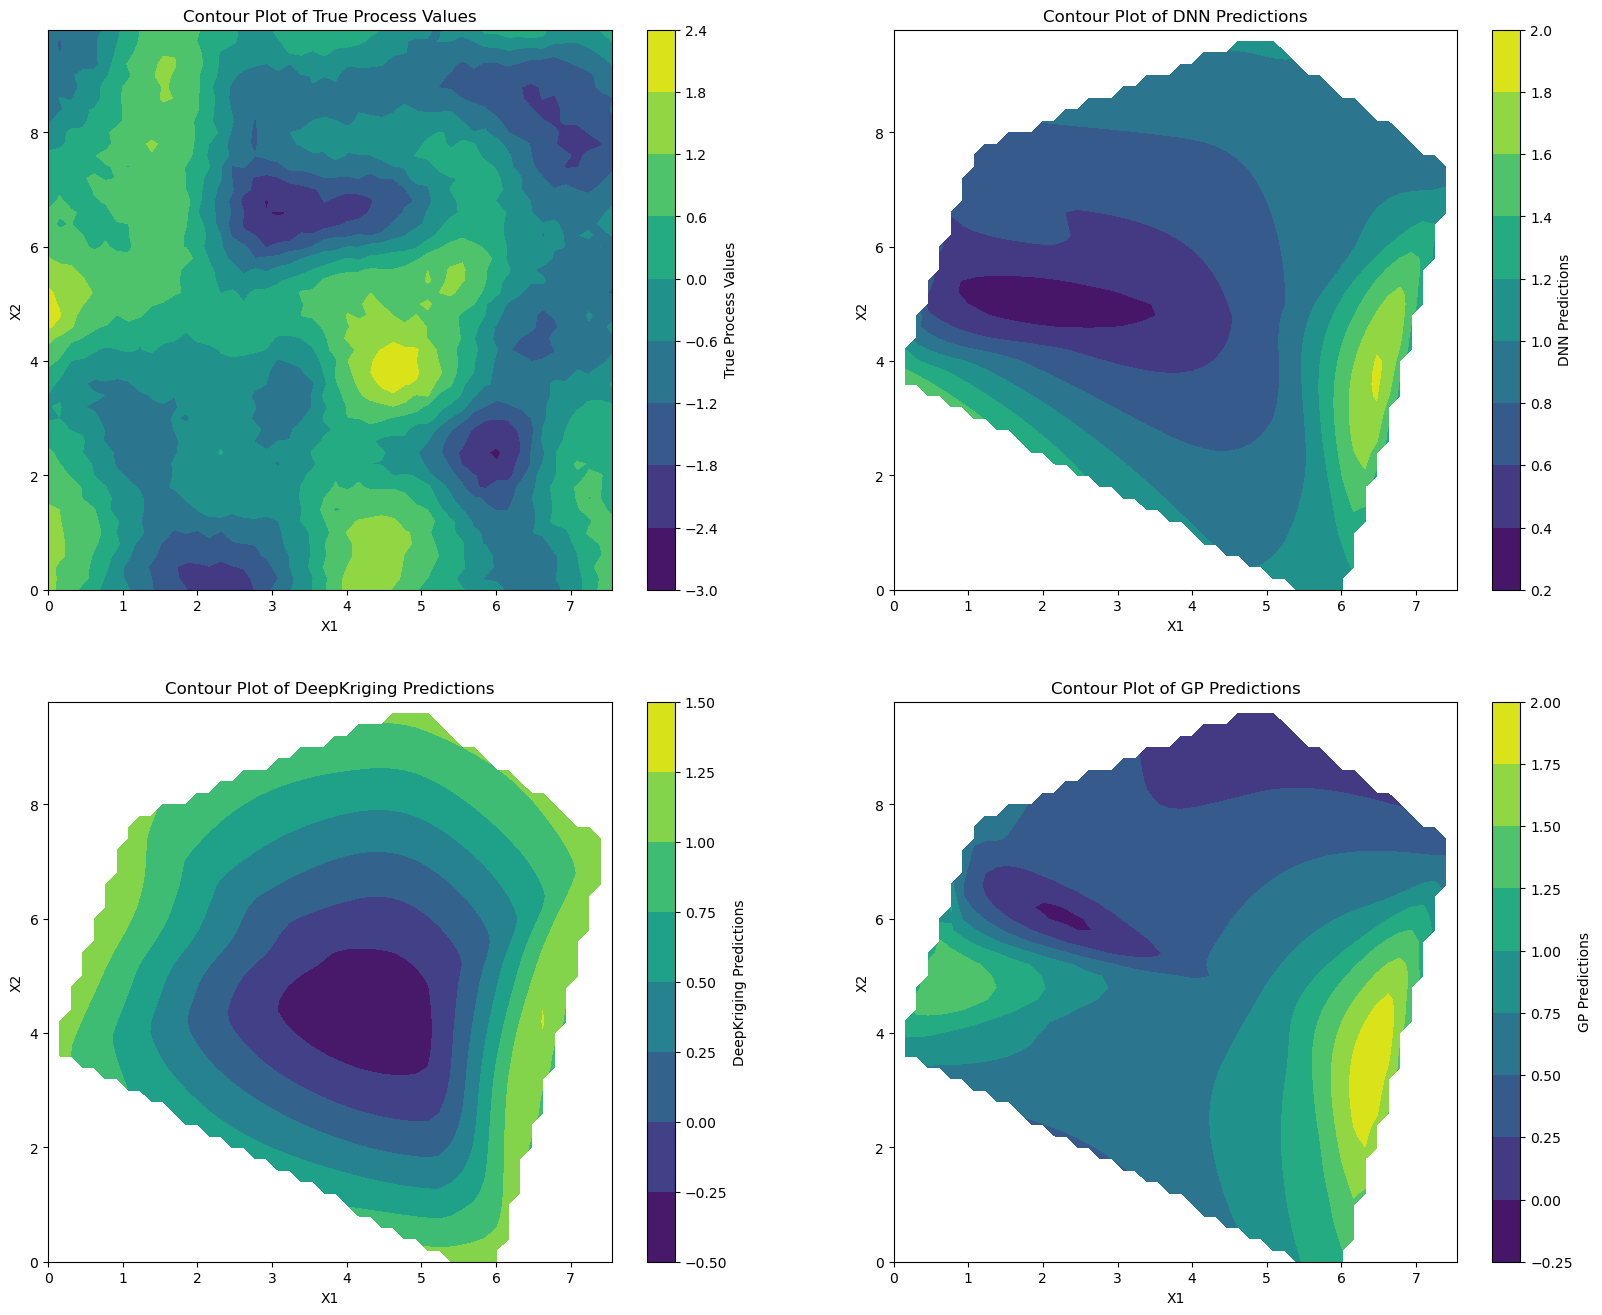

In [8]:
from scipy.interpolate import griddata

# Assuming s_test is 2D with shape (n_samples, 2)
x1 = s_test[:, 0].numpy()
x2 = s_test[:, 1].numpy()
x1_grid, x2_grid = np.meshgrid(np.linspace(x1.min(), x1.max(), 50), np.linspace(x2.min(), x2.max(), 50))

# Interpolate DNN predictions to match the grid shape
y_pred_1_grid = griddata(s_test.numpy(), y_pred_1, (x1_grid, x2_grid), method='cubic')
y_pred_1_grid = np.squeeze(y_pred_1_grid)  # Remove the extra dimension

# Interpolate DeepKriging predictions to match the grid shape
y_pred_2_grid = griddata(s_test.numpy(), y_pred_2, (x1_grid, x2_grid), method='cubic')
y_pred_2_grid = np.squeeze(y_pred_2_grid)  # Remove the extra dimension

# Interpolate GP predictions to match the grid shape (no need to squeeze, it's already correct)
y_pred_gp_grid = griddata(s_test.numpy(), y_pred_gp, (x1_grid, x2_grid), method='cubic')

# Reshape the true process values to the grid shape (already done earlier)
process_values_grid = process_values.reshape(x1_grid.shape)

# Plot the contour plots for the true process values and the predictions
fig, ax = plt.subplots(2, 2, figsize=(20, 16))

# True Process Values
contour1 = ax[0, 0].contourf(x1_grid, x2_grid, process_values_grid, cmap='viridis')
fig.colorbar(contour1, ax=ax[0, 0], label='True Process Values')
ax[0, 0].set_title("Contour Plot of True Process Values")
ax[0, 0].set_xlabel("X1")
ax[0, 0].set_ylabel("X2")

# DNN with Spatial Coordinates
contour2 = ax[0, 1].contourf(x1_grid, x2_grid, y_pred_1_grid, cmap='viridis')
fig.colorbar(contour2, ax=ax[0, 1], label='DNN Predictions')
ax[0, 1].set_title("Contour Plot of DNN Predictions")
ax[0, 1].set_xlabel("X1")
ax[0, 1].set_ylabel("X2")

# DeepKriging Predictions
contour3 = ax[1, 0].contourf(x1_grid, x2_grid, y_pred_2_grid, cmap='viridis')
fig.colorbar(contour3, ax=ax[1, 0], label='DeepKriging Predictions')
ax[1, 0].set_title("Contour Plot of DeepKriging Predictions")
ax[1, 0].set_xlabel("X1")
ax[1, 0].set_ylabel("X2")

# GP Predictions
contour4 = ax[1, 1].contourf(x1_grid, x2_grid, y_pred_gp_grid, cmap='viridis')
fig.colorbar(contour4, ax=ax[1, 1], label='GP Predictions')
ax[1, 1].set_title("Contour Plot of GP Predictions")
ax[1, 1].set_xlabel("X1")
ax[1, 1].set_ylabel("X2")

plt.show()

In [9]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate RMSE and MAPE for DNN (Model 1)
rmse_dnn = rmse(y_test.numpy(), y_pred_1)
mape_dnn = mape(y_test.numpy(), y_pred_1)
print(f"RMSE (DNN): {rmse_dnn}")
print(f"MAPE (DNN): {mape_dnn}")

# Calculate RMSE and MAPE for DeepKriging (Model 2)
rmse_deepkriging = rmse(y_test.numpy(), y_pred_2)
mape_deepkriging = mape(y_test.numpy(), y_pred_2)
print(f"RMSE (DeepKriging): {rmse_deepkriging}")
print(f"MAPE (DeepKriging): {mape_deepkriging}")

# Calculate RMSE and MAPE for Basic GP
rmse_gp = rmse(y_test.numpy(), y_pred_gp)
mape_gp = mape(y_test.numpy(), y_pred_gp)
print(f"RMSE (GP): {rmse_gp}")
print(f"MAPE (GP): {mape_gp}")

RMSE (DNN): 0.6447479128837585
MAPE (DNN): 175.39418029785156
RMSE (DeepKriging): 0.6547403931617737
MAPE (DeepKriging): 177.16195678710938
RMSE (GP): 0.6768427888661014
MAPE (GP): 139.3040302641042
